In [1]:
import os
import math
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema, find_peaks
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import cv2
import glob
import scipy.stats as stats

In [2]:
#def wavelet_detection_synthetic_trajectory():
def time_acc_dec_jerk_def():
    # state_change_label: 0 for A-F, 1 for A-D, 2 for S-A, 3 for F-D, 4 for D-S
    total_time_step = 200
    time_resolution = 0.1
    
    acceleration_range = [1, 3]
    acc_resolution = 0.5
    # (3-1)/0.5 + 1 = 5
    total_num_acc = int((acceleration_range[1] - acceleration_range[0]) / acc_resolution) + 1
    
    deceleration_range = [-3, -1]
    dec_resolution = 0.5
    total_num_dec = int((deceleration_range[1] - deceleration_range[0]) / dec_resolution) + 1
    
    # absolute_jerk_value = 2  # absolute value
    jerk_value_range = [0.5, 1, 1.5, 2, 2.5]  # absolute value
    change_point_range = [8, 12]
    change_point_resolution = 0.5
    # (12-8)/0.5 = 8
    total_num_change_point = int((change_point_range[1] - change_point_range[0]) / change_point_resolution)
    
    return total_time_step, time_resolution, acceleration_range, acc_resolution, total_num_acc, deceleration_range, dec_resolution, total_num_dec, jerk_value_range, change_point_range, change_point_resolution, total_num_change_point

In [3]:
def A_F_trajectory_generation():
    global all_state_change_point_record
    global all_synthetic_trj
    
    current_state_change_label = 0
    current_starting_speed = 0
    current_veh_id = 0
    
    total_time_step, time_resolution, acceleration_range, acc_resolution, total_num_acc, deceleration_range, dec_resolution, total_num_dec, jerk_value_range, change_point_range, change_point_resolution, total_num_change_point = time_acc_dec_jerk_def()
    
    # i in {0, 1, ... 7}
    for i in range(total_num_change_point):
        # {8, 8.5, 9, ...11.5}
        current_change_point_time = change_point_range[0] + i * change_point_resolution
        # {0, 1, ... 4}
        for j in range(total_num_acc):
            # {1, 1.5, 2, ... 3}
            current_acc = acceleration_range[0] + acc_resolution * j
            # {0, 1, ... 4}
            for k in range(len(jerk_value_range)):
                current_absolute_jerk = jerk_value_range[k]
                
                # print some info
                print_str = 'Current generating ' + str(current_veh_id) + 'th vehicle synthetic trajectory '
                print(print_str)
                
                # init data space
                single_scenario_trj = pd.DataFrame(np.zeros((total_time_step, 6)), 
                                                   columns=['veh_id', 'local_time', 'position', 
                                                            'speed', 'acceleration', 'state_change_label'])
                single_change_point_record = pd.DataFrame(np.zeros((1, 9)), 
                                                          columns=['veh_id', 'test_acc', 'test_dec', 'test_jerk', 
                                                                   'change_point_time_1', 'change_point_time_2', 
                                                                   'zero_acc_time', 'mid_change_point_time', 
                                                                   'state_change_label'])
                
                single_change_point_record.loc[:, 'state_change_label'] = current_state_change_label
                single_change_point_record.loc[:, 'veh_id'] = current_veh_id
                single_change_point_record.loc[:, 'test_acc'] = current_acc
                single_change_point_record.loc[:, 'test_dec'] = '-'
                single_change_point_record.loc[:, 'test_jerk'] = current_absolute_jerk
                # for 1st example: 8 - (1 / 0.5) 
                single_change_point_record.loc[:, 'change_point_time_1'] = current_change_point_time - (current_acc / current_absolute_jerk)
                # 8
                single_change_point_record.loc[:, 'change_point_time_2'] = current_change_point_time
                # 0.5 * (6 + 8) = 7
                single_change_point_record.loc[:, 'mid_change_point_time'] = 0.5 * (single_change_point_record.loc[:, 'change_point_time_1'] + single_change_point_record.loc[:, 'change_point_time_2'])
                # 8
                single_change_point_record.loc[:, 'zero_acc_time'] = current_change_point_time
                # 0
                single_scenario_trj.loc[:, 'state_change_label'] = current_state_change_label
                # 0
                single_scenario_trj.loc[:, 'veh_id'] = current_veh_id
                
                # calculate the acceleration first
                # (8/0.1)
                change_point_step = round(current_change_point_time / time_resolution)
                # 80 - ((1/0.5)/0.1)
                acc_change_step = change_point_step - round((current_acc / current_absolute_jerk) / time_resolution)
                for t_step in range(total_time_step):
                    if t_step <= acc_change_step:
                        single_scenario_trj.loc[t_step, 'acceleration'] = current_acc
                    elif t_step < change_point_step:
                        single_scenario_trj.loc[t_step, 'acceleration'] = single_scenario_trj.loc[t_step - 1, 'acceleration'] - current_absolute_jerk * time_resolution
                    else:
                        single_scenario_trj.loc[t_step, 'acceleration'] = 0
                        
                # update speed and position
                for t_step in range(total_time_step):
                    single_scenario_trj.loc[t_step, 'local_time'] = t_step * time_resolution
                    if t_step == 0:
                        single_scenario_trj.loc[t_step, 'speed'] = current_starting_speed
                        single_scenario_trj.loc[t_step, 'position'] = 0
                    else:
                        previous_speed = single_scenario_trj.loc[t_step - 1, 'speed']
                        previous_position = single_scenario_trj.loc[t_step - 1, 'position']
                        single_scenario_trj.loc[t_step, 'speed'] = previous_speed + 0.5 * (single_scenario_trj.loc[t_step - 1, 'acceleration'] +single_scenario_trj.loc[t_step, 'acceleration']) * time_resolution
                        single_scenario_trj.loc[t_step, 'position'] = previous_position + 0.5 * (single_scenario_trj.loc[t_step, 'speed'] + previous_speed) * time_resolution
                all_state_change_point_record = all_state_change_point_record.append(single_change_point_record)
                all_synthetic_trj = all_synthetic_trj.append(single_scenario_trj)
                current_veh_id += 1

In [4]:
def A_D_trajectory_generation():
    global all_state_change_point_record
    global all_synthetic_trj
    
    current_state_change_label = 1
    current_starting_speed = 0
    current_veh_id = 200
    
    total_time_step, time_resolution, acceleration_range, acc_resolution, total_num_acc, deceleration_range, dec_resolution, total_num_dec, jerk_value_range, change_point_range, change_point_resolution, total_num_change_point = time_acc_dec_jerk_def()
    
    # random_deceleration = np.random.uniform(deceleration_range[0], deceleration_range[1], total_num_acc * total_num_change_point)
    for i in range(total_num_change_point):
        current_change_point_time = change_point_range[0] + i * change_point_resolution
        for j in range(total_num_acc):
            current_acc = acceleration_range[0] + acc_resolution * j
            for k in range(len(jerk_value_range)):
                current_absolute_jerk = jerk_value_range[k]
                print_str = 'Current generating ' + str(current_veh_id) + 'th vehicle synthetic trajectory '
                print(print_str)
                # the deceleration will be designated randomly
                # current_dec = random_deceleration[total_num_acc * i + j]
                acc_time = (current_change_point_time - (current_acc / current_absolute_jerk))
                current_dec = -(current_acc * acc_time) / (20 - acc_time)
                current_absolute_dec = abs(current_dec)
                single_scenario_trj = pd.DataFrame(np.zeros((total_time_step, 6)),
                                                   columns=['veh_id', 'local_time', 'position', 'speed', 'acceleration', 'state_change_label'])
                single_change_point_record = pd.DataFrame(np.zeros((1, 9)), columns=['veh_id', 'test_acc', 'test_dec', 'test_jerk',
                                                                   'change_point_time_1',
                                                                   'change_point_time_2',
                                                                   'zero_acc_time',
                                                                   'mid_change_point_time',
                                                                   'state_change_label'])
                single_change_point_record.loc[:, 'state_change_label'] = current_state_change_label
                single_change_point_record.loc[:, 'veh_id'] = current_veh_id
                single_change_point_record.loc[:, 'test_acc'] = current_acc
                single_change_point_record.loc[:, 'test_dec'] = current_dec
                single_change_point_record.loc[:, 'test_jerk'] = current_absolute_jerk
                single_change_point_record.loc[:, 'change_point_time_1'] = current_change_point_time - (current_acc / current_absolute_jerk)
                single_change_point_record.loc[:, 'change_point_time_2'] = current_change_point_time + (current_absolute_dec / current_absolute_jerk)
                single_change_point_record.loc[:, 'zero_acc_time'] = current_change_point_time
                single_change_point_record.loc[:, 'mid_change_point_time'] = 0.5 * (single_change_point_record.loc[:, 'change_point_time_1'] + single_change_point_record.loc[:, 'change_point_time_2'])
                single_scenario_trj.loc[:, 'state_change_label'] = current_state_change_label
                single_scenario_trj.loc[:, 'veh_id'] = current_veh_id
                # calculate the acceleration first
                change_point_step = int(current_change_point_time / time_resolution)
                acc_change_step = change_point_step - round((current_acc / current_absolute_jerk) / time_resolution)
                dec_change_step = change_point_step + round((current_absolute_dec / current_absolute_jerk) / time_resolution)
                for t_step in range(total_time_step):
                    if t_step <= acc_change_step:
                        single_scenario_trj.loc[t_step, 'acceleration'] = current_acc
                    elif t_step < dec_change_step:
                        single_scenario_trj.loc[t_step, 'acceleration'] = single_scenario_trj.loc[t_step - 1, 'acceleration'] - current_absolute_jerk * time_resolution
                    else:
                        single_scenario_trj.loc[t_step, 'acceleration'] = current_dec
                # update speed and position
                for t_step in range(total_time_step):
                    single_scenario_trj.loc[t_step, 'local_time'] = t_step * time_resolution
                    if t_step == 0:
                        single_scenario_trj.loc[t_step, 'speed'] = current_starting_speed
                        single_scenario_trj.loc[t_step, 'position'] = 0
                    else:
                        previous_speed = single_scenario_trj.loc[t_step - 1, 'speed']
                        previous_position = single_scenario_trj.loc[t_step - 1, 'position']
                        single_scenario_trj.loc[t_step, 'speed'] = previous_speed + 0.5 * (single_scenario_trj.loc[t_step - 1, 'acceleration'] +single_scenario_trj.loc[t_step, 'acceleration']) * time_resolution
                        single_scenario_trj.loc[t_step, 'position'] = previous_position + 0.5 * (single_scenario_trj.loc[t_step, 'speed'] + previous_speed) * time_resolution
                all_state_change_point_record = all_state_change_point_record.append(single_change_point_record)
                all_synthetic_trj = all_synthetic_trj.append(single_scenario_trj)
                current_veh_id += 1

In [5]:
def S_A_trajectory_generation():
    global all_state_change_point_record
    global all_synthetic_trj
    current_state_change_label = 2
    current_starting_speed = 0
    current_veh_id = 400
    total_time_step, time_resolution, acceleration_range, acc_resolution, total_num_acc, deceleration_range, dec_resolution, total_num_dec, jerk_value_range, change_point_range, change_point_resolution, total_num_change_point = time_acc_dec_jerk_def()
    
    for i in range(total_num_change_point):
        current_change_point_time = change_point_range[0] + i * change_point_resolution
        for j in range(total_num_acc):
            current_acc = acceleration_range[0] + acc_resolution * j
            for k in range(len(jerk_value_range)):
                current_absolute_jerk = jerk_value_range[k]
                print_str = 'Current generating ' + str(current_veh_id) + 'th vehicle synthetic trajectory '
                print(print_str)
                single_scenario_trj = pd.DataFrame(np.zeros((total_time_step, 6)), columns=['veh_id', 'local_time', 'position', 'speed', 'acceleration', 'state_change_label'])
                single_change_point_record = pd.DataFrame(np.zeros((1, 9)), columns=['veh_id', 'test_acc', 'test_dec', 'test_jerk',
                                                                   'change_point_time_1',
                                                                   'change_point_time_2',
                                                                   'zero_acc_time',
                                                                   'mid_change_point_time',
                                                                   'state_change_label'])
                single_change_point_record.loc[:, 'state_change_label'] = current_state_change_label
                single_change_point_record.loc[:, 'veh_id'] = current_veh_id
                single_change_point_record.loc[:, 'test_acc'] = current_acc
                single_change_point_record.loc[:, 'test_dec'] = '-'
                single_change_point_record.loc[:, 'test_jerk'] = current_absolute_jerk
                single_change_point_record.loc[:, 'change_point_time_1'] = current_change_point_time
                single_change_point_record.loc[:, 'change_point_time_2'] = current_change_point_time + (current_acc / current_absolute_jerk)
                single_change_point_record.loc[:, 'zero_acc_time'] = current_change_point_time
                single_change_point_record.loc[:, 'mid_change_point_time'] = 0.5 * (single_change_point_record.loc[:, 'change_point_time_1'] + single_change_point_record.loc[:, 'change_point_time_2'])
                single_scenario_trj.loc[:, 'state_change_label'] = current_state_change_label
                single_scenario_trj.loc[:, 'veh_id'] = current_veh_id
                # calculate the acceleration first
                change_point_step = round(current_change_point_time / time_resolution)
                acc_change_step = change_point_step + round((current_acc / current_absolute_jerk) / time_resolution)
                for t_step in range(total_time_step):
                    if t_step <= change_point_step:
                        single_scenario_trj.loc[t_step, 'acceleration'] = 0
                    elif t_step < acc_change_step:
                        single_scenario_trj.loc[t_step, 'acceleration'] = single_scenario_trj.loc[t_step - 1, 'acceleration'] + current_absolute_jerk * time_resolution
                    else:
                        single_scenario_trj.loc[t_step, 'acceleration'] = current_acc
                # update speed and position
                for t_step in range(total_time_step):
                    single_scenario_trj.loc[t_step, 'local_time'] = t_step * time_resolution
                    if t_step == 0:
                        single_scenario_trj.loc[t_step, 'speed'] = current_starting_speed
                        single_scenario_trj.loc[t_step, 'position'] = 0
                    else:
                        previous_speed = single_scenario_trj.loc[t_step - 1, 'speed']
                        previous_position = single_scenario_trj.loc[t_step - 1, 'position']
                        single_scenario_trj.loc[t_step, 'speed'] = previous_speed + 0.5 * (single_scenario_trj.loc[t_step - 1, 'acceleration'] +single_scenario_trj.loc[t_step, 'acceleration']) * time_resolution
                        single_scenario_trj.loc[t_step, 'position'] = previous_position + 0.5 * (single_scenario_trj.loc[t_step, 'speed'] + previous_speed) * time_resolution
                all_state_change_point_record = all_state_change_point_record.append(single_change_point_record)
                all_synthetic_trj = all_synthetic_trj.append(single_scenario_trj)
                current_veh_id += 1

In [6]:
def F_D_trajectory_generation():
    global all_state_change_point_record
    global all_synthetic_trj
    current_state_change_label = 3
    current_starting_speed = 36
    current_veh_id = 600
    total_time_step, time_resolution, acceleration_range, acc_resolution, total_num_acc, deceleration_range, dec_resolution, total_num_dec, jerk_value_range, change_point_range, change_point_resolution, total_num_change_point = time_acc_dec_jerk_def()
    
    for i in range(total_num_change_point):
        current_change_point_time = change_point_range[0] + i * change_point_resolution
        for j in range(total_num_dec):
            current_dec = deceleration_range[0] + dec_resolution * j
            absolute_dec = abs(current_dec)
            for k in range(len(jerk_value_range)):
                current_absolute_jerk = jerk_value_range[k]
                print_str = 'Current generating ' + str(current_veh_id) + 'th vehicle synthetic trajectory '
                print(print_str)
                single_scenario_trj = pd.DataFrame(np.zeros((total_time_step, 6)), columns=['veh_id', 'local_time', 'position', 'speed', 'acceleration', 'state_change_label'])
                single_change_point_record = pd.DataFrame(np.zeros((1, 9)), columns=['veh_id', 'test_acc', 'test_dec', 'test_jerk',
                                                                   'change_point_time_1',
                                                                   'change_point_time_2',
                                                                   'zero_acc_time',
                                                                   'mid_change_point_time',
                                                                   'state_change_label'])
                single_change_point_record.loc[:, 'state_change_label'] = current_state_change_label
                single_change_point_record.loc[:, 'veh_id'] = current_veh_id
                single_change_point_record.loc[:, 'test_acc'] = '-'
                single_change_point_record.loc[:, 'test_dec'] = current_dec
                single_change_point_record.loc[:, 'test_jerk'] = current_absolute_jerk
                single_change_point_record.loc[:, 'change_point_time_1'] = current_change_point_time
                single_change_point_record.loc[:, 'change_point_time_2'] = current_change_point_time + (absolute_dec / current_absolute_jerk)
                single_change_point_record.loc[:, 'zero_acc_time'] = current_change_point_time
                single_change_point_record.loc[:, 'mid_change_point_time'] = 0.5 * (single_change_point_record.loc[:, 'change_point_time_1'] + single_change_point_record.loc[:, 'change_point_time_2'])
                single_scenario_trj.loc[:, 'state_change_label'] = current_state_change_label
                single_scenario_trj.loc[:, 'veh_id'] = current_veh_id
                # calculate the acceleration first
                change_point_step = round(current_change_point_time / time_resolution)
                acc_change_step = change_point_step + round((absolute_dec / current_absolute_jerk) / time_resolution)
                for t_step in range(total_time_step):
                    if t_step <= change_point_step:
                        single_scenario_trj.loc[t_step, 'acceleration'] = 0
                    elif t_step < acc_change_step:
                        single_scenario_trj.loc[t_step, 'acceleration'] = single_scenario_trj.loc[t_step - 1, 'acceleration'] - current_absolute_jerk * time_resolution
                    else:
                        single_scenario_trj.loc[t_step, 'acceleration'] = current_dec
                # update speed and position
                for t_step in range(total_time_step):
                    single_scenario_trj.loc[t_step, 'local_time'] = t_step * time_resolution
                    if t_step == 0:
                        single_scenario_trj.loc[t_step, 'speed'] = current_starting_speed
                        single_scenario_trj.loc[t_step, 'position'] = 0
                    else:
                        previous_speed = single_scenario_trj.loc[t_step - 1, 'speed']
                        previous_position = single_scenario_trj.loc[t_step - 1, 'position']
                        single_scenario_trj.loc[t_step, 'speed'] = previous_speed + 0.5 * (single_scenario_trj.loc[t_step - 1, 'acceleration'] +single_scenario_trj.loc[t_step, 'acceleration']) * time_resolution
                        single_scenario_trj.loc[t_step, 'position'] = previous_position + 0.5 * (single_scenario_trj.loc[t_step, 'speed'] + previous_speed) * time_resolution
                all_state_change_point_record = all_state_change_point_record.append(single_change_point_record)
                all_synthetic_trj = all_synthetic_trj.append(single_scenario_trj)
                current_veh_id += 1

In [7]:
def D_S_trajectory_generation():
    global all_state_change_point_record
    global all_synthetic_trj
    current_state_change_label = 4
    # note that starting speed is set dynamically
    current_veh_id = 800
    
    total_time_step, time_resolution, acceleration_range, acc_resolution, total_num_acc, deceleration_range, dec_resolution, total_num_dec, jerk_value_range, change_point_range, change_point_resolution, total_num_change_point = time_acc_dec_jerk_def()
    
    for i in range(total_num_change_point):
        current_change_point_time = change_point_range[0] + i * change_point_resolution
        for j in range(total_num_dec):
            current_dec = deceleration_range[0] + dec_resolution * j
            absolute_dec = abs(current_dec)
            for k in range(len(jerk_value_range)):
                current_absolute_jerk = jerk_value_range[k]
                print_str = 'Current generating ' + str(current_veh_id) + 'th vehicle synthetic trajectory '
                print(print_str)
                current_starting_speed = (current_change_point_time - (absolute_dec / current_absolute_jerk)) * absolute_dec + 0.5 * absolute_dec * (absolute_dec / current_absolute_jerk)
                single_scenario_trj = pd.DataFrame(np.zeros((total_time_step, 6)), columns=['veh_id', 'local_time', 'position', 'speed', 'acceleration', 'state_change_label'])
                single_change_point_record = pd.DataFrame(np.zeros((1, 9)), columns=['veh_id', 'test_acc', 'test_dec', 'test_jerk',
                                                                   'change_point_time_1',
                                                                   'change_point_time_2',
                                                                   'zero_acc_time',
                                                                   'mid_change_point_time',
                                                                   'state_change_label'])
                single_change_point_record.loc[:, 'state_change_label'] = current_state_change_label
                single_change_point_record.loc[:, 'veh_id'] = current_veh_id
                single_change_point_record.loc[:, 'test_acc'] = '-'
                single_change_point_record.loc[:, 'test_dec'] = current_dec
                single_change_point_record.loc[:, 'test_jerk'] = current_absolute_jerk
                single_change_point_record.loc[:, 'change_point_time_1'] = current_change_point_time - (absolute_dec / current_absolute_jerk)
                single_change_point_record.loc[:, 'change_point_time_2'] = current_change_point_time
                single_change_point_record.loc[:, 'zero_acc_time'] = current_change_point_time
                single_change_point_record.loc[:, 'mid_change_point_time'] = 0.5 * (single_change_point_record.loc[:, 'change_point_time_1'] + single_change_point_record.loc[:, 'change_point_time_2'])
                single_scenario_trj.loc[:, 'state_change_label'] = current_state_change_label
                single_scenario_trj.loc[:, 'veh_id'] = current_veh_id
                # calculate the acceleration first
                change_point_step = round(current_change_point_time / time_resolution)
                acc_change_step = change_point_step - round((absolute_dec / current_absolute_jerk) / time_resolution)
                for t_step in range(total_time_step):
                    if t_step <= acc_change_step:
                        single_scenario_trj.loc[t_step, 'acceleration'] = current_dec
                    elif t_step < change_point_step:
                        single_scenario_trj.loc[t_step, 'acceleration'] = single_scenario_trj.loc[t_step - 1, 'acceleration'] + current_absolute_jerk * time_resolution
                    else:
                        single_scenario_trj.loc[t_step, 'acceleration'] = 0
                # update speed and position
                for t_step in range(total_time_step):
                    single_scenario_trj.loc[t_step, 'local_time'] = t_step * time_resolution
                    if t_step == 0:
                        single_scenario_trj.loc[t_step, 'speed'] = current_starting_speed
                        single_scenario_trj.loc[t_step, 'position'] = 0
                    elif t_step >= change_point_step:
                        previous_speed = single_scenario_trj.loc[t_step - 1, 'speed']
                        previous_position = single_scenario_trj.loc[t_step - 1, 'position']
                        single_scenario_trj.loc[t_step, 'speed'] = 0
                        single_scenario_trj.loc[t_step, 'position'] = previous_position + 0.5 * (single_scenario_trj.loc[t_step, 'speed'] + previous_speed) * time_resolution
                    else:
                        previous_speed = single_scenario_trj.loc[t_step - 1, 'speed']
                        previous_position = single_scenario_trj.loc[t_step - 1, 'position']
                        single_scenario_trj.loc[t_step, 'speed'] = previous_speed + 0.5 * (single_scenario_trj.loc[t_step - 1, 'acceleration'] +single_scenario_trj.loc[t_step, 'acceleration']) * time_resolution
                        if single_scenario_trj.loc[t_step, 'speed'] < 0:
                            # modify the change point if speed drop to 0 in advance
                            single_scenario_trj.loc[t_step, 'speed'] = 0
                            single_scenario_trj.loc[t_step, 'acceleration'] = 0
                            single_change_point_record.loc[:, 'change_point_time_2'] = t_step * time_resolution
                        single_scenario_trj.loc[t_step, 'position'] = previous_position + 0.5 * (single_scenario_trj.loc[t_step, 'speed'] + previous_speed) * time_resolution
                all_state_change_point_record = all_state_change_point_record.append(single_change_point_record)
                all_synthetic_trj = all_synthetic_trj.append(single_scenario_trj)
                current_veh_id += 1

In [8]:
synthetic_trj_generation_label = 0
wavelet_scale_sensitivity_analysis_label = 0
wavelet_scale_sensitivity_video_generation = 0
local_maxima_lines_test_label = 0

In [9]:
if synthetic_trj_generation_label:
    all_state_change_point_record = pd.DataFrame()
    all_synthetic_trj = pd.DataFrame()
    #wavelet_detection_synthetic_trajectory()
    A_F_trajectory_generation()
    A_D_trajectory_generation()
    S_A_trajectory_generation()
    F_D_trajectory_generation()
    D_S_trajectory_generation()
    all_state_change_point_record.to_csv('./data_save/all_state_change_point_record.csv')
    all_synthetic_trj.to_csv('./data_save/all_synthetic_trj.csv')

# above is generate data

# next , need to apply data to the MM

In [18]:
def wavelet_energy_cal(data, scale_in):
    # first we need to extend the signal, or the boundary effect will impact the results severely
    # the analyzed data is speed, we will keep the acceleration of the first and last point the same while extending the signal
    # the extend length will be 100 points on each of the side
    extend_length = 200
    starting_acc = (data[1] - data[0]) / 0.1
    end_acc = (data[-1] - data[-2]) / 0.1
    starting_extension = [None] * extend_length
    starting_extension[-1] = data[0] - starting_acc * 0.1
    end_extension = [None] * extend_length
    end_extension[0] = data[-1] + end_acc * 0.1
    for i in range(1, extend_length):
        starting_extension[-i - 1] = starting_extension[-i] - starting_acc * 0.1
    for j in range(extend_length - 1):
        end_extension[j + 1] = end_extension[j] + end_acc * 0.1
    data = starting_extension + data
    data = data + end_extension
    # We will use Mexican Hat wavelet
    wname = "mexh"
    # Decompose the signal
    # note that Mexican hat is continuous wavelet
    # coeffs, freqs = pywt.cwt(data, scales=np.arange(1, 32), wavelet=wname)
    coeffs, freqs = pywt.cwt(data, scales=np.arange(1, scale_in), wavelet=wname)
    # calculate the energy
    averaged_energy = np.mean(np.square(coeffs), axis=0)
    averaged_energy = np.delete(averaged_energy, range(extend_length))
    averaged_energy = np.delete(averaged_energy, (np.arange(extend_length) + 1) * (-1))
    return averaged_energy

In [44]:
def wavelet_energy_cal_with_local_maxima(data, scale_in):
    # in this version, we will calculate the local maxima wavelet coefficients for every time step
    # first we need to extend the signal, or the boundary effect will impact the results severely
    # the analyzed data is speed, we will keep the acceleration of the first and last point the same while extending the signal
    # the extend length will be 100 points on each of the side
    extend_length = 100
    starting_acc = (data[1] - data[0]) / 0.1
    end_acc = (data[-1] - data[-2]) / 0.1
    starting_extension = [None] * extend_length
    starting_extension[-1] = data[0] - starting_acc * 0.1
    end_extension = [None] * extend_length
    end_extension[0] = data[-1] + end_acc * 0.1
    for i in range(1, extend_length):
        starting_extension[-i - 1] = starting_extension[-i] - starting_acc * 0.1
    for j in range(extend_length - 1):
        end_extension[j + 1] = end_extension[j] + end_acc * 0.1
    data = starting_extension + data
    data = data + end_extension
    # We will use Mexican Hat wavelet
    wname = "mexh"
    # Decompose the signal
    # note that Mexican hat is continuous wavelet
    # coeffs, freqs = pywt.cwt(data, scales=np.arange(1, 32), wavelet=wname)
    coeffs, freqs = pywt.cwt(data, scales=np.arange(1, scale_in), wavelet=wname)
    # calculate the energy
    averaged_energy = np.mean(np.square(coeffs), axis=0)
    averaged_energy = np.delete(averaged_energy, range(extend_length))
    averaged_energy = np.delete(averaged_energy, (np.arange(extend_length) + 1) * (-1))
    # calculate the local maxima at each time step: for plotting local maxima lines
    # note that the local maxima information is the scale position, not the exact coefficient values
    # note that absolute values of wavelet coefficients should be used
    # note that the method of finding the local maxima is: under certain scale, find all the time correspinding to all the local maxima
    absolute_coeffs = np.absolute(coeffs)
    absolute_coeffs = np.delete(absolute_coeffs, range(extend_length), axis=1)
    absolute_coeffs = np.delete(absolute_coeffs, (np.arange(extend_length) + 1) * (-1), axis=1)
    local_maxima_points = pd.DataFrame()
    for i in range(scale_in - 1):
        current_scale_coeffs = absolute_coeffs[i, :]
        
#         local_maxima_index = argrelextrema(current_scale_coeffs, np.greater, order=2)
        #use find_peaks instead of argrelextrema, round the coef array to avoid some numerical errors
        local_maxima_index = find_peaks(np.round(current_scale_coeffs, 6), width=2)
        local_maxima_index = local_maxima_index[0]
        
        maxima_info = pd.DataFrame(np.zeros((len(local_maxima_index), 2)), columns=['time_index', 'scale_id'])
#         if i == 18:
#             print(current_scale_coeffs[80:100])
#             plt.figure()
#             plt.plot(current_scale_coeffs)
#             print(local_maxima_index)
        for max_i in range(len(local_maxima_index)):
            maxima_info.loc[max_i, 'time_index'] = local_maxima_index[max_i]  # time index position
            maxima_info.loc[max_i, 'scale_id'] = i + 1  # scale id
        local_maxima_points = local_maxima_points.append(maxima_info)
    #return averaged_energy, local_maxima_points
    return local_maxima_points

# test code, need to be grouped up later

In [41]:
def wavelet_energy_plot_with_local_maxima_lines(follower_trj_in, follower_local_maxima_points):
    follower_speed = list(follower_trj_in.loc[:, 'speed'])
    current_trj_initial_time = follower_trj_in['time'].iat[0]
    follower_local_maxima_points.loc[:, 'time_index'] = follower_local_maxima_points.loc[:, 'time_index'] * 0.1 + current_trj_initial_time
    
    
    follower_line = '-b'
    follower_label = 'syn'
    plt.subplot(2, 1, 1)
    plt.plot(follower_trj_in['time'], follower_trj_in['speed'], follower_line, linewidth=0.5,
             label=follower_label)
    plt.ylabel('Speed (m/s)')
    #plt.ylim([0, 35])
    plt.xlim([follower_trj_in['time'].min(), follower_trj_in['time'].max()])
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

    ax.xaxis.set_minor_locator(MultipleLocator(0.2))
    
    plt.legend(prop={'size': 6})

    
    
    follower_marker = 'ro'
    plt.subplot(2, 1, 2)
    #print(follower_local_maxima_points)
    plt.plot(follower_local_maxima_points.loc[:, 'time_index'], follower_local_maxima_points.loc[:, 'scale_id'], follower_marker, markersize=1, label=follower_label)
    #plt.ylim([0, 10])
    plt.ylim(bottom=1)
    plt.xlim([follower_trj_in['time'].min(), follower_trj_in['time'].max()])
    
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    
    ax.xaxis.set_minor_locator(MultipleLocator(0.2))
    
    plt.xlabel('Time (s)')
    plt.ylabel('Wavelet Modulus')
    plt.legend(prop={'size': 6})
    
    plt.show()
    

In [42]:
def wavelet_detection_scale_sensitivity_analysis(all_state_change_point_record_in, all_synthetic_trj_in):
    # create a new col in the dataframe and name it 'index' with the value from 0 ~ end
    # i dont know if we need (inplace=True) here ?
    all_state_change_point_record_in.reset_index(inplace=True)
    
    # make a Copy for the syn data.  tips: for the .copy() deep=True is the default which means we dont need to write here. LOL.
    scale_sensitivity_analysis_results = all_state_change_point_record_in.copy(deep=True)
    
    # set the scale range, usually do not need to be too big probab less than 50?
    scale_list = range(2, 128)
    # scale_list = range(64, 65)
    
    # initialize results columns and set all of them to 0
    for i in range(len(scale_list)):
        current_scale_name = 'scale_' + str(scale_list[i]) + '_time'
        current_mae_name = 'scale_' + str(scale_list[i]) + '_mae'
        scale_sensitivity_analysis_results.loc[:, current_scale_name] = 0
        scale_sensitivity_analysis_results.loc[:, current_mae_name] = 0
        
    # before making the video, delete all the frame jpgs
    # but i(jieming sun) dont wanna to make video, but it doesnt matter , so just leave this part of code here.
    filelist = glob.glob(os.path.join('figure_save/CF_analysis/scale_sensitivity_analysis/temp_figures/', "*.jpg"))
    for f in filelist:
        os.remove(f)
    
    # here i in from 0 to 999, which i think is used to extract data for diff car.
    for i in range(0, len(all_state_change_point_record_in.loc[:, 'veh_id'])):
        
#         if i not in [920, 945]:
#             continue

        # .at() cool function , Get value at specified row/column pair
        current_veh_id = all_state_change_point_record_in.at[i, 'veh_id']
        print_content = 'Now in vehicle: ' + str(current_veh_id)
        print(print_content)
        
        # Get the corresponding Record data.
        current_change_point_record = all_state_change_point_record_in.loc[i, :]
        # Obtain the corresponding 200 timestamp data
        current_veh_trj = all_synthetic_trj_in.loc[all_synthetic_trj_in['veh_id'] == current_veh_id, :]
        # Convert the pandas series to List, can use both list() or list(), only a little diff.
        current_veh_speed = list(current_veh_trj.loc[:, 'speed'])
        
        # recursive with diff scale num.
        WE=[]
        for max_scale in scale_list:
            if max_scale == 2:
                WE.append(wavelet_energy_cal(current_veh_speed, max_scale))
            else:
                current_wavelet_energy = wavelet_energy_cal(current_veh_speed, max_scale)
                WE = np.concatenate((WE, [current_wavelet_energy]), axis=0)
            
        if True == True:
            max_scale = scale_list[-1]+1
            # here is the change we make, we change the function below.
            # now is return the local_maxima_points
            current_local_maxima_points = wavelet_energy_cal_with_local_maxima(current_veh_speed, max_scale)
                        
            # because i dont want to create video , so i havent fix the function synthetic_trj_wavelet_energy_plot()
            # if anyone wanna use , need to fix before use.
            # if wavelet_scale_sensitivity_video_generation:
                #synthetic_trj_wavelet_energy_plot(current_veh_trj, current_wavelet_energy, current_change_point_record, max_scale)
            
            #current_scale_name = 'scale_' + str(max_scale) + '_time'
            #current_mae_name = 'scale_' + str(max_scale) + '_mae'
            
            new_data = pd.DataFrame()
            new_data['time'] = current_veh_trj['local_time']
            new_data['speed'] = current_veh_trj['speed']
            
            # change the timestamp into real time_index
            current_local_maxima_points_01 = current_local_maxima_points.copy()
            current_local_maxima_points_01.time_index = current_local_maxima_points.time_index * 0.1
            
            add_energy_to_LMP = current_local_maxima_points_01.copy()
            ene = []
            for index, row in add_energy_to_LMP.iterrows():
                if row.scale_id == 1:
                    ene.append(0)
                else:
                    ene.append(WE[int(row.scale_id)-2][int(round(row.time_index,1)*10)])
            
            add_energy_to_LMP['Corresponding_energy'] = ene
            grouped = add_energy_to_LMP.groupby(['scale_id'])
#             result = pd.DataFrame(columns=['time_index', 'scale_id', 'Corresponding_energy'])
#             print('max energy time\n', result)
            for name,group in grouped:
                current_scale_name = 'scale_' + str(int(name)) + '_time'
                current_mae_name = 'scale_' + str(int(name)) + '_mae'
                if name > 1.0:
                    result = group[group.Corresponding_energy == max(group.Corresponding_energy)]
                    #print('result.time_index', result.time_index.values)
                    #print('scale_sensitivity_analysis_results', scale_sensitivity_analysis_results.loc[i, current_scale_name])
                    scale_sensitivity_analysis_results.loc[i, current_scale_name] = result.time_index.values[0]
                    scale_sensitivity_analysis_results.loc[i, current_mae_name] = abs(result.time_index.values[0] - scale_sensitivity_analysis_results.loc[i, 'mid_change_point_time'])
                    
            
            #wavelet_energy_plot_with_local_maxima_lines(new_data, current_local_maxima_points)
    scale_sensitivity_analysis_results.to_csv('./data_save/scale_sensitivity_analysis_results.csv')
    return new_data, WE, current_local_maxima_points

Now in vehicle: 920.0
[5.97190942 6.12447228 6.26513965 6.39288227 6.50675253 6.60602905
 6.68996523 6.7579132  6.80930337 6.84374105 6.86106684 6.86106684
 6.84374105 6.80930337 6.7579132  6.68996523 6.60602905 6.50675253
 6.39288227 6.26513965]
[90]
Now in vehicle: 945.0
[5.06797659 5.26373011 5.45318622 5.63510622 5.80840426 5.97190942
 6.12447228 6.26513965 6.39288227 6.50675253 6.60602905 6.68996523
 6.7579132  6.80930337 6.84374105 6.86106684 6.86106684 6.84374105
 6.80930337 6.7579132 ]
[95]


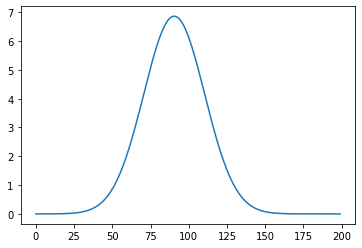

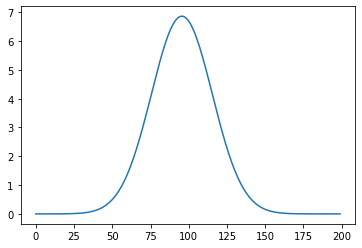

In [43]:
all_state_change_point_record = pd.read_csv('./data_save/all_state_change_point_record.csv', header=0)
all_synthetic_trj = pd.read_csv('./data_save/all_synthetic_trj.csv', header=0)

return_info, WE, current_local_maxima_points = wavelet_detection_scale_sensitivity_analysis(all_state_change_point_record, all_synthetic_trj)

In [26]:
def test(follower_trj_in, follower_local_maxima_points):
    follower_speed = list(follower_trj_in.loc[:, 'speed'])
    current_trj_initial_time = follower_trj_in['time'].iat[0]
    follower_local_maxima_points.loc[:, 'time_index'] = follower_local_maxima_points.loc[:, 'time_index'] + current_trj_initial_time
    
    
    follower_line = '-b'
    follower_label = 'syn'
    plt.subplot(2, 1, 1)
    plt.plot(follower_trj_in['time'], follower_trj_in['speed'], follower_line, linewidth=0.5,
             label=follower_label)
    plt.ylabel('Speed (m/s)')
    #plt.ylim([0, 35])
    plt.xlim([follower_trj_in['time'].min(), follower_trj_in['time'].max()])
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

    ax.xaxis.set_minor_locator(MultipleLocator(0.2))
    
    plt.legend(prop={'size': 6})

    
    
    follower_marker = 'ro'
    plt.subplot(2, 1, 2)
    #print(follower_local_maxima_points)
    plt.plot(follower_local_maxima_points.loc[:, 'time_index'], follower_local_maxima_points.loc[:, 'scale_id'], follower_marker, markersize=1, label=follower_label)
    #plt.ylim([0, 10])
    plt.ylim(bottom=1)
    plt.xlim([follower_trj_in['time'].min(), follower_trj_in['time'].max()])
    
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    
    ax.xaxis.set_minor_locator(MultipleLocator(0.2))
    
    plt.xlabel('Time (s)')
    plt.ylabel('Wavelet Modulus')
    plt.legend(prop={'size': 6})
    
    plt.show()
    

In [27]:
def scale_sensitivity_analysis_results_plot():
    scale_sensitivity_analysis_results = pd.read_csv('data_save/scale_sensitivity_analysis_results.csv', header=0)
    scale_list = list(range(2, 128))
    mae_list = list(range(128 - 2))
    for i in range(len(scale_list)):
        current_mae_name = 'scale_' + str(scale_list[i]) + '_mae'
        mae_list[i] = scale_sensitivity_analysis_results.loc[:, current_mae_name].mean()
    plt.figure()
    plt.plot(scale_list, mae_list, 'b-^', markersize=1, linewidth=1)
    plt.title('Wavelet MaxModule Scale Sensitivity Analysis')
    plt.ylabel('Mean Absolute Error (s)')
    plt.xlabel('Scale')
    plt.xlim(xmin=0)
    plt.ylim(ymin=0)
    # plt.grid(linestyle='dotted')
    fig1_save_title = 'figure_save/CF_analysis/' + 'Wavelet Scale Sensitivity Analysis.png'
    plt.savefig(fig1_save_title, dpi=600)
    plt.close('all')

In [28]:
scale_sensitivity_analysis_results_plot()

In [29]:
scale_sensitivity_analysis_results = pd.read_csv('data_save/scale_sensitivity_analysis_results.csv', header=0)
scale_list = list(range(2, 128))
mae_list = list(range(128 - 2))
for i in range(len(scale_list)):
    current_mae_name = 'scale_' + str(scale_list[i]) + '_mae'
    mae_list[i] = scale_sensitivity_analysis_results.loc[:, current_mae_name].mean()

In [35]:
mae_list = np.array(mae_list)
np.where(mae_list < 0.1)[0] + 2

array([ 2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46], dtype=int64)